# Analysis of SourceXtractor++ catalog

This notebook gives some tools to analyse the results of SourceXtractor++, such as plotting the detected sources on the detection image, comparing the data, model and residual images, and looking at the photometric spectrum for different sources.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits, ascii
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.visualization.wcsaxes import add_scalebar
import astropy.units as u
from astropy.table import Table
import dja_sepp

We begin by selecting and opening the SE++ catalog.

In [2]:
field = 'GDS'
with fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/*sci_cutout_sepp_cat.fits")[0]) as hdul:
    cat = Table(hdul[1].data)

Here are all the column names :

In [3]:
print(cat.keys())

['pixel_centroid_x', 'pixel_centroid_y', 'world_centroid_alpha', 'world_centroid_delta', 'source_id', 'detection_id', 'group_id', 'group_stamp_top', 'group_stamp_left', 'group_stamp_width', 'group_stamp_height', 'source_flags', 'n_detected_pixels', 'n_core_pixel', 'auto_flux', 'auto_flux_err', 'auto_mag', 'auto_mag_err', 'auto_flags', 'flux_radius', 'snrratio', 'ellipse_a', 'ellipse_b', 'ellipse_theta', 'ellipse_cxx', 'ellipse_cyy', 'ellipse_cxy', 'area', 'elongation', 'ellipticity', 'fmf_reduced_chi_2', 'fmf_iterations', 'fmf_stop_reason', 'fmf_duration', 'fmf_flags', 'fmf_chi2_per_meta', 'fmf_iterations_per_meta', 'fmf_meta_iterations', 'X_MODEL', 'X_MODEL_err', 'Y_MODEL', 'Y_MODEL_err', 'RA_MODEL', 'RA_MODEL_err', 'DEC_MODEL', 'DEC_MODEL_err', 'RADIUS', 'RADIUS_err', 'AXRATIO', 'AXRATIO_err', 'ANGLE', 'ANGLE_err', 'E1', 'E1_err', 'E2', 'E2_err', 'SERSIC', 'SERSIC_err', 'X_SERSIC', 'X_SERSIC_err', 'DET-IMG_RADIUS', 'DET-IMG_RADIUS_err', 'DET-IMG_AXRATIO', 'DET-IMG_AXRATIO_err', 'DET-

## Full image

We begin by looking at the detected sources overlayed with an image used with SE++, and by comparing the data, model and residual images for a given filter.

In [5]:
filter = 'f200w'
hdu       = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/*{filter}*sci_cutout.fits")[0], memmap=True)[0]
model_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/checkimages/model*{filter}*sci_cutout_1.fits")[0], memmap=True)[0]
resid_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/checkimages/resid*{filter}*sci_cutout_1.fits")[0], memmap=True)[0]

Overlay of detected sources with the image

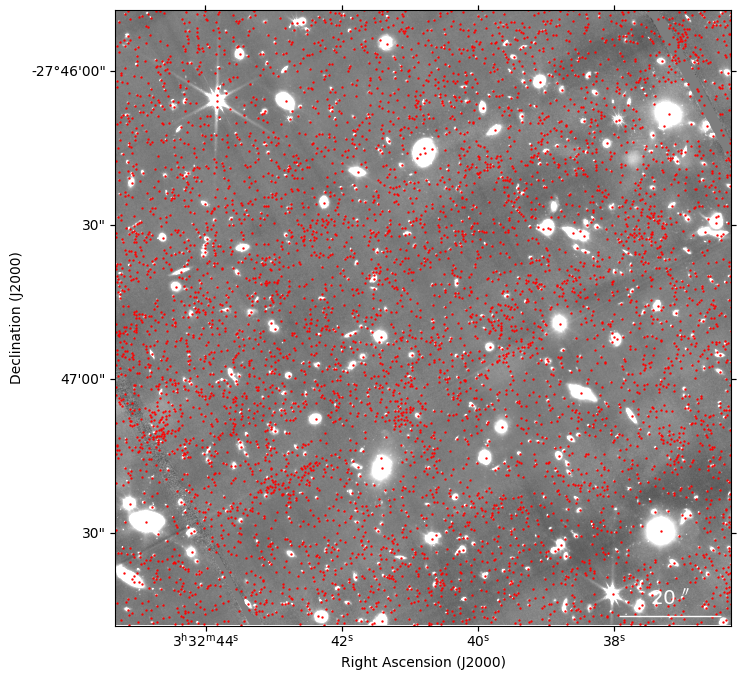

In [7]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':WCS(hdu.header)})
norm = ImageNormalize(hdu.data, interval=ZScaleInterval())
ax.imshow(hdu.data, cmap='gray', origin='lower', norm=norm)
ax.scatter(cat['world_centroid_alpha'], cat['world_centroid_delta'], transform=ax.get_transform('world'), c='r', s=0.5)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
dja_sepp.utils.add_good_scalebar(ax, WCS(hdu.header))
plt.show()

Comparison of data, model and residual image

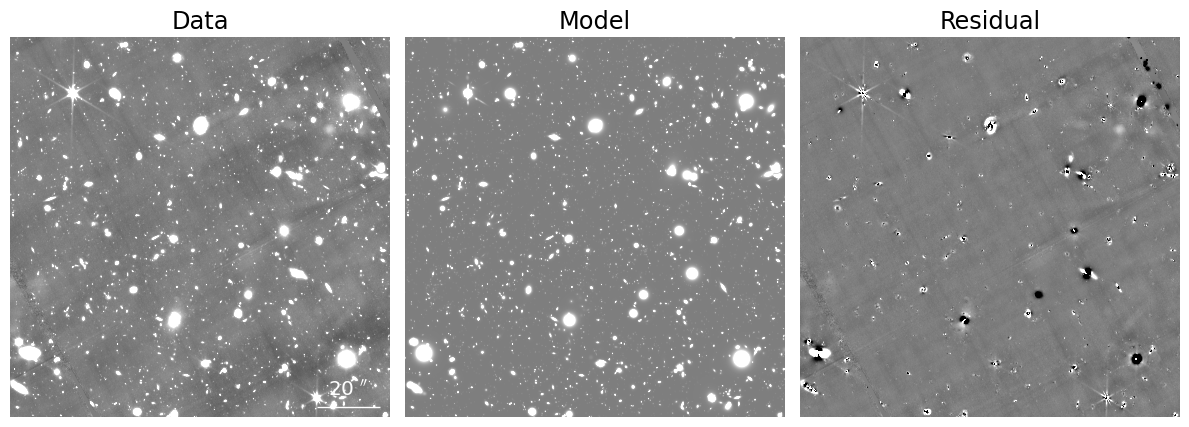

In [8]:
fig = plt.figure(figsize=(12,8))
#Plots data
wcs = WCS(hdu.header)
ax = fig.add_subplot(1,3,1, projection=wcs)
norm = ImageNormalize(hdu.data, interval=ZScaleInterval())
ax.imshow(hdu.data, cmap='gray', origin='lower', norm=norm)
dja_sepp.utils.add_good_scalebar(ax, wcs)
ax.set_axis_off()
ax.set_title("Data", size='xx-large')
# Plots model
ax_model = fig.add_subplot(1,3,2, projection=wcs)
ax_model.imshow(model_hdu.data, cmap='gray', origin='lower', norm=norm)
ax_model.set_axis_off()
ax_model.set_title("Model", size='xx-large')
# Plots residual
ax_resid = fig.add_subplot(1,3,3, projection=wcs)
ax_resid.imshow(resid_hdu.data, cmap='gray', origin='lower', norm=norm)
ax_resid.set_axis_off()
ax_resid.set_title("Residual", size='xx-large')

fig.tight_layout()
plt.show()

## Zoom on one source

Now, we can look at the data, model and residual images for a specific source, in all the measured bands.

/home/ec2-user/miniconda3/envs/dawn-310/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: divide by zero encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/ec2-user/miniconda3/envs/dawn-310/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


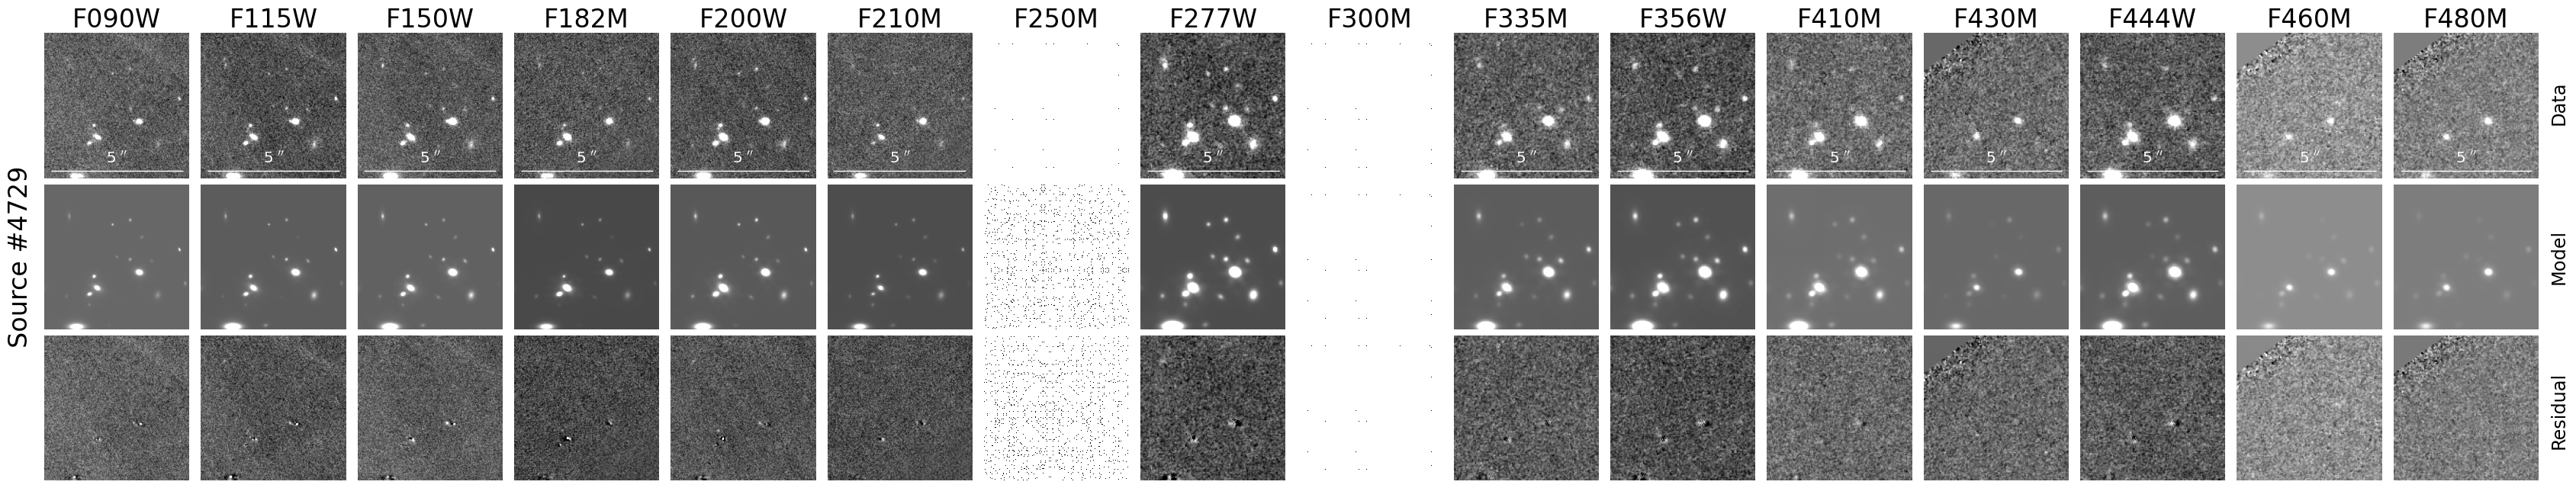

In [12]:
filter_list = [key.split("_")[-1].lower() for key in cat.keys() if (('MAG' in key) and ('err' not in key))]

id = 4729
dja_sepp.utils.show_source(id, cat, filter_list, fov=5*u.arcsec,
                           data_folder=f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}",
                           model_folder=f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/checkimages",
                           resid_folder=f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/checkimages", 
                           data_suffix="sci_cutout.fits",
                           model_suffix="sci_cutout_1.fits",
                           resid_suffix="sci_cutout_1.fits")

## Photometric spectrum

Finally, using the SE++ catalog, we can trace the photometric spectrum for a given source.

The `plot_filters` function plots the filters throughput, from the JWST documentation.

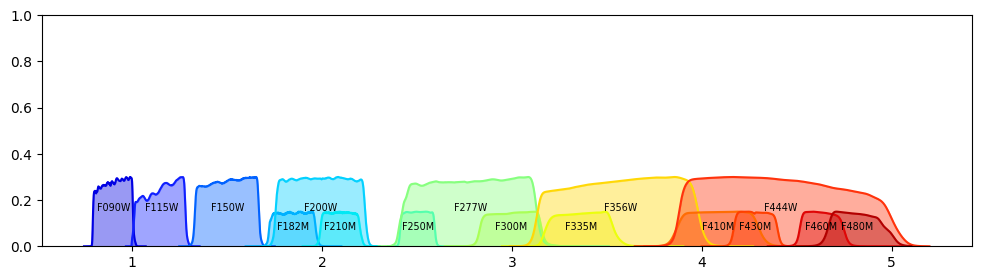

In [14]:
fig, ax = plt.subplots(figsize=(12,3))
dja_sepp.utils.plot_filters(ax, filter_list=None, scale=0.3, names=True)
ax.set_ylim(0,1)
plt.show()

And finally, we can plot the photometric spectrum for a few sources from our catalog.

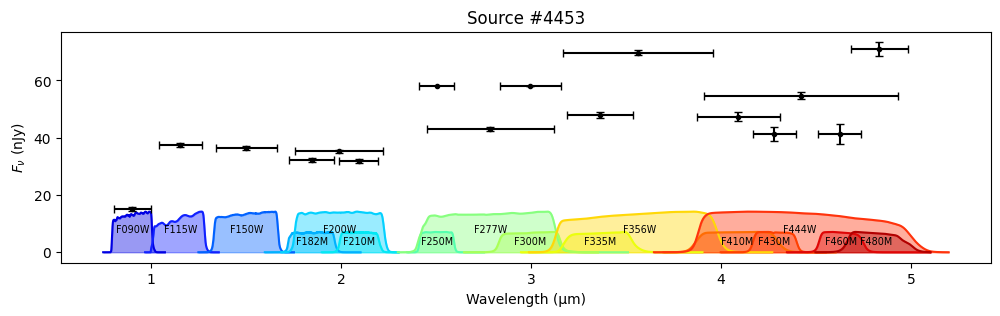

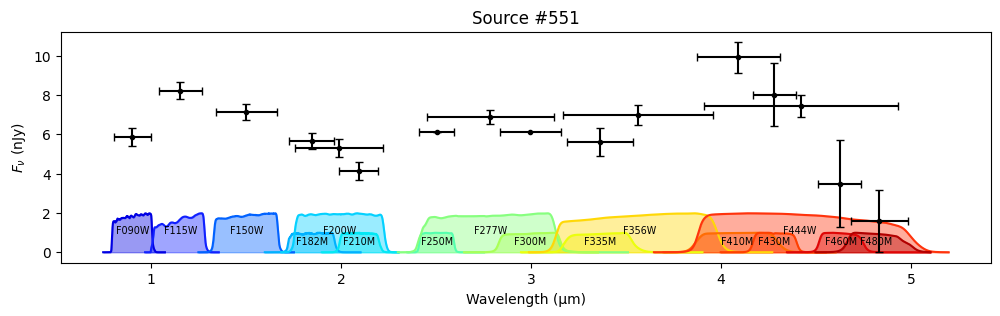

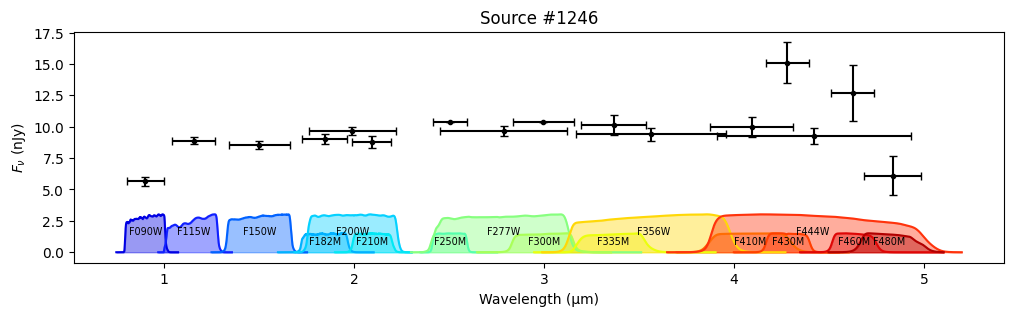

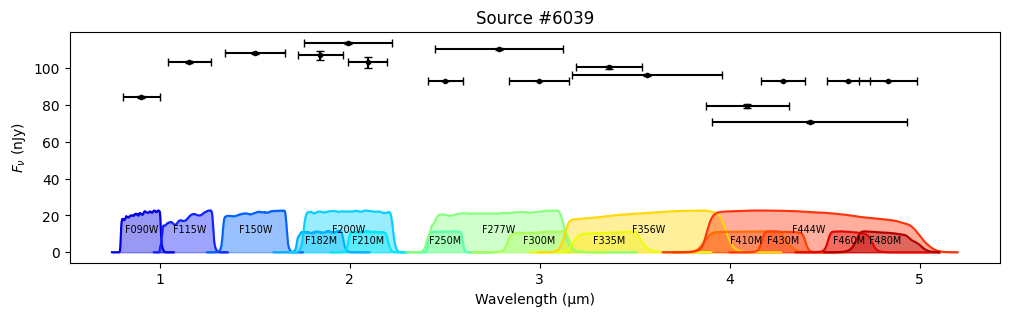

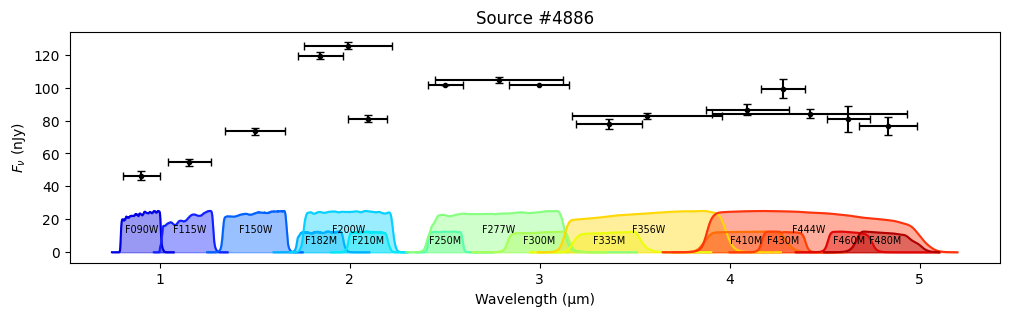

In [28]:
for id in np.random.randint(0, len(cat), 5):
    dja_sepp.utils.plot_photometric_spectrum(id, cat, mag=False, title=f"Source #{id}")